## Linear Regression notebook

In this notebook, various linear regression (LR) models are trained.  A baseline LR model is trained on the training set with no feature engineering or feature selection.  By testing all possible feature selections, we create the best LR model (without feature engineering).  With feature engineering and 1300 Optuna trials, we create a third, improved, LR model.  The RMSLE error of these three models predicting on the testing set is: 

-No feature engineering, no feature selection: 0.45056\
-No feature engineering, feature selection: 0.34825\
-Feature engineering, feature selection: 0.08976

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import optuna
from optuna.samplers import TPESampler

In [3]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


# Linear Regression with no feature selection or feature engineering

C:\Users\eblac\AppData\Local\Temp\ipykernel_15904\1331040239.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


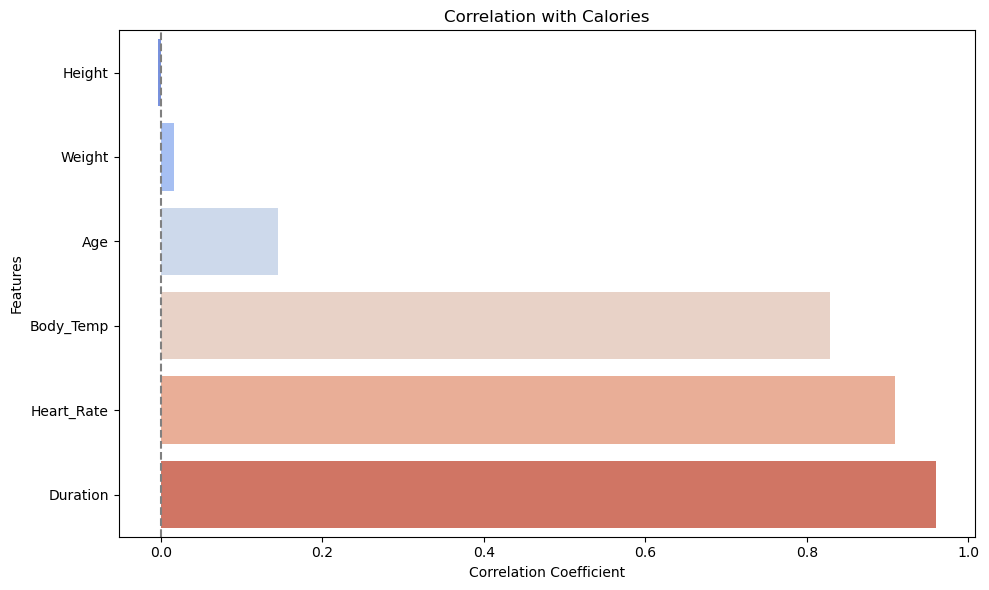

In [11]:
# Compute correlations
correlations = train.corr(numeric_only=True)['Calories'].drop('Calories').sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlation with Calories')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

Create a linear regression model using all features (with one-hot encoding on the 'Sex' column).

Train prediction: 0.4534304935914087
Test prediction: 0.4515506340261045


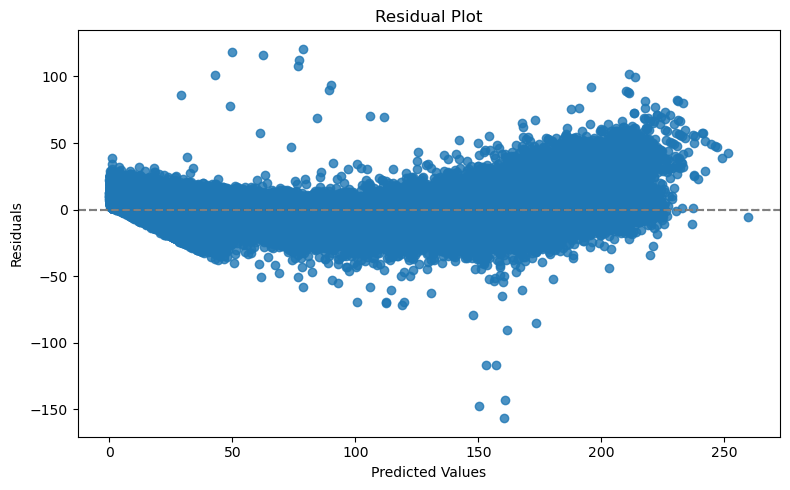

       id    Calories
0  750000   21.426392
1  750001  114.704977
2  750002   93.199665
3  750003  130.770204
4  750004   73.695691

count    250000.000000
mean         88.677433
std          60.766215
min           0.000921
25%          34.327102
50%          82.768266
75%         139.512313
max         247.332418
Name: Calories, dtype: float64


In [6]:
# kaggle score 0.45056 private, 0.45856 public (LinReg_8.csv)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(train.drop(columns='Calories'), drop_first=True), train['Calories'], test_size=0.2, random_state=724)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 1

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmsle(train_pred, y_train))
print("Test prediction:", rmsle(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=predictions, y=y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

pred = model.predict(pd.get_dummies(test, drop_first=True))

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = pred
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("LinReg_8.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

### Test all possible feature combinations to get the best linear regression model (without feature engineering).

In [ ]:
def powerset(s):
    ''''''''''''''''
    Input: A list s.
    Output: The powerset of s minus the empty set.
    Example: s = ['a', 'b']
    list(powerset(s)) will return [['a'], ['b'], ['a', 'b']].
    '''''''''''''''
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1, 1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

Find the best combination of features!

In [45]:
X = pd.get_dummies(train.drop(columns="Calories"), drop_first=True)
y = train['Calories']

col_combo = list(powerset(X.columns.tolist()))

err = []

for feats in col_combo:
    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=724)

    scores = []

    # Perform cross-validation manually
    for train_index, test_index in kf.split(X[feats]):
        X_train, X_val = X[feats].loc[train_index], X[feats].loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]
        
        # Train and evaluate
        model = LinearRegression()
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)

        predictions[predictions <= 0] = 1
        predictions[predictions > 320] = 300
        
        # Calculate the score
        score = rmsle(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSLE
    err.append(np.mean(scores))


min_value = min(err) #find the min value
min_index = err.index(min_value) #find the index of the min value

print(f"Minimum value: {min_value}")
print(f"Index of minimum value: {min_index}, which corresponds to", col_combo[min_index])

Minimum value: 0.3491225748891206
Index of minimum value: 39, which corresponds to ['Duration', 'Body_Temp']


Train the model and make the submission file.

Train prediction: 0.3485653533556597
Test prediction: 0.3510109498290161


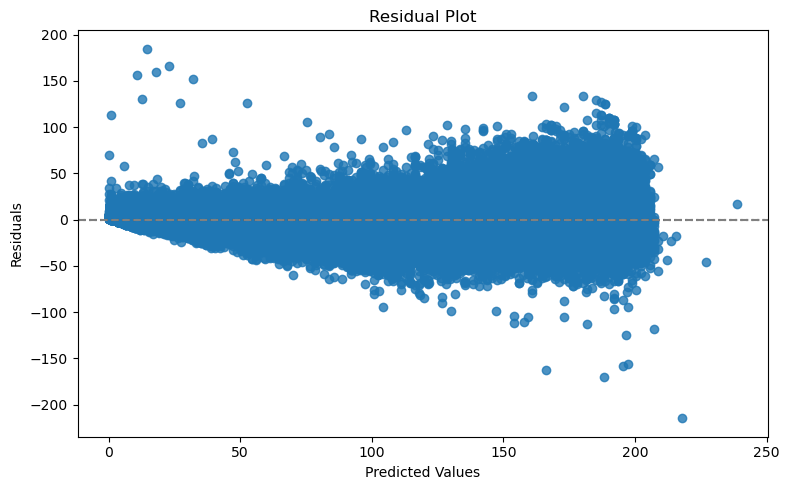

       id    Calories
0  750000   20.041532
1  750001  119.837424
2  750002   87.215581
3  750003  118.177398
4  750004   85.555555

count    250000.000000
mean         88.282476
std          60.096133
min           0.159220
25%          33.592076
50%          83.625192
75%         140.568748
max         225.192069
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.34825 private, 0.34650 public (LinReg_9.csv)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns='Calories')[col_combo[min_index]], y, test_size=0.2, random_state=724)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 1

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmsle(train_pred, y_train))
print("Test prediction:", rmsle(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=predictions, y=y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

pred = model.predict(test.drop(columns='id')[col_combo[min_index]])

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = pred
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("LinReg_9.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

# Feature engineering
Add product terms, body mass index (BMI), and Body_Temp squared

In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)

    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

Add these features to the training and testing set.

In [ ]:
X = add_feats(train, numerical_features)
y = train['Calories']
test_mod = add_feats(test, numerical_features)

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Body_Temp_-_min_sq,Age_x_Height,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,36,189,82,26,101,41.0,22.955684,15.21,6804,...,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0
1,female,64,163,60,8,85,39.7,22.582709,6.76,10432,...,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5
2,female,51,161,64,7,84,39.8,24.690405,7.29,8211,...,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2
3,male,20,192,90,25,105,40.7,24.414062,12.96,3840,...,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5
4,female,38,166,61,25,102,40.6,22.136740,12.25,6308,...,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2


In [37]:
train_FE = pd.concat([X, y], axis=1)

train_FE.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Body_Temp_-_min_sq,Age_x_Height,...,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp,Calories
0,male,36,189,82,26,101,41.0,22.955684,15.21,6804,...,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0,150
1,female,64,163,60,8,85,39.7,22.582709,6.76,10432,...,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5,34
2,female,51,161,64,7,84,39.8,24.690405,7.29,8211,...,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2,29
3,male,20,192,90,25,105,40.7,24.414062,12.96,3840,...,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5,140
4,female,38,166,61,25,102,40.6,22.136740,12.25,6308,...,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2,146


Which features are correlated with Calories?

C:\Users\eblac\AppData\Local\Temp\ipykernel_15044\2785241079.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


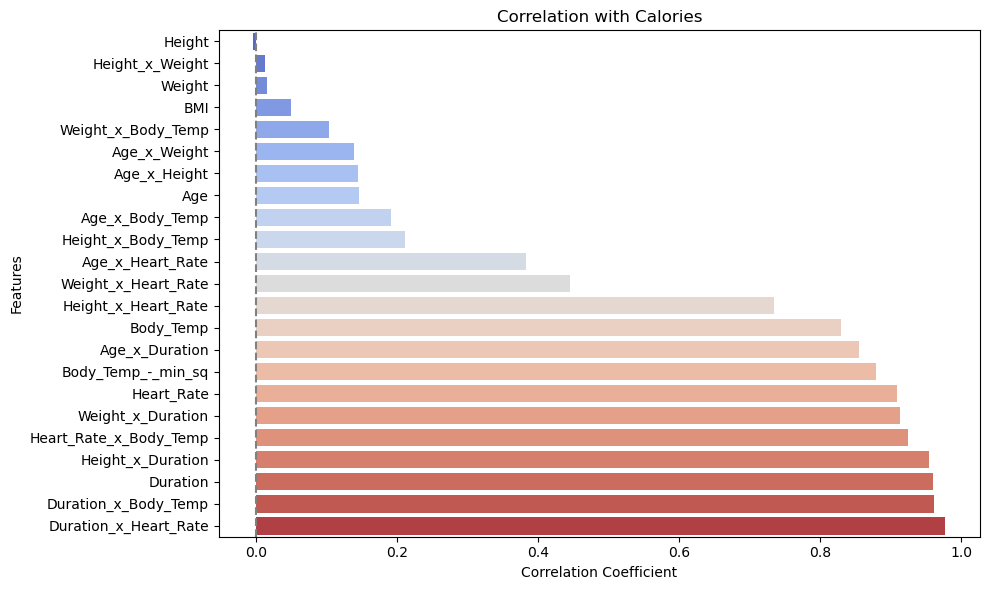

In [38]:
# Compute correlations
correlations = train_FE.corr(numeric_only=True)['Calories'].drop('Calories').sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlation with Calories')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

Make a linear regression model only using features with correlation coefficient 0.8 and above.

In [40]:
feats = ['Duration_x_Heart_Rate',
         'Duration_x_Body_Temp',
         'Duration', 'Height_x_Duration',
         'Heart_Rate_x_Body_Temp',
         'Weight_x_Duration',
         'Heart_Rate',
         'Age_x_Duration',
         'Body_Temp',
         'Body_Temp_-_min_sq'
         ]

X[feats].head()

,Duration_x_Heart_Rate,Duration_x_Body_Temp,Duration,Height_x_Duration,Heart_Rate_x_Body_Temp,Weight_x_Duration,Heart_Rate,Age_x_Duration,Body_Temp,Body_Temp_-_min_sq
0,2626,1066.0,26,4914,4141.0,2132,101,936,41.0,15.21
1,680,317.6,8,1304,3374.5,480,85,512,39.7,6.76
2,588,278.6,7,1127,3343.2,448,84,357,39.8,7.29
3,2625,1017.5,25,4800,4273.5,2250,105,500,40.7,12.96
4,2550,1015.0,25,4150,4141.2,1525,102,950,40.6,12.25


Train prediction: 0.1043205979246302
Test prediction: 0.10535532027423587


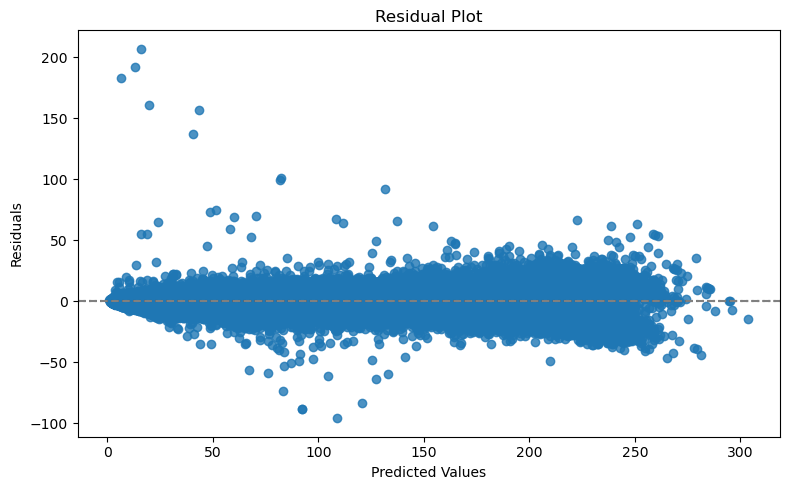

In [41]:
# Linear regression model using top 10 features with correlation to Calories
# kaggle score 0.10376 private, 0.10287 public

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[feats], y, test_size=0.2, random_state=431)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 1

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmsle(train_pred, y_train))
print("Test prediction:", rmsle(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=predictions, y=y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

Train prediction: 0.09511969951600706
Test prediction: 0.09694185190022957


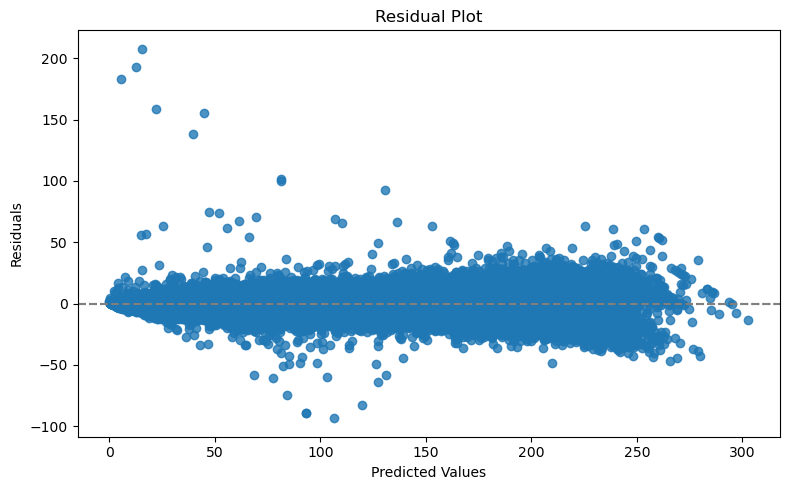

In [ ]:
# Linear regression model using top 10 features and one-hot encoded Sex feature with correlation to Calories
# kaggle score 0.09345 private, 0.9344 public (LinReg_4.csv)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X[['Sex'] + feats], drop_first=True), y, test_size=0.2, random_state=431)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 1

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmsle(train_pred, y_train))
print("Test prediction:", rmsle(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=predictions, y=y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

## Use Optuna to select the best features.

In [18]:
feature_names = X.columns.tolist()

def objective(trial):
    # Select features: binary on/off switch for each
    selected = [
        f for f in feature_names 
        if trial.suggest_categorical(f'use_{f}', [True, False])
    ]

    # Avoid empty feature set
    if not selected:
        return float('inf')

    X_selected = pd.get_dummies(X[selected], drop_first=True)


    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=724)

    scores = []

    # Perform cross-validation manually
    for train_index, test_index in kf.split(X_selected):
        X_train, X_val = X_selected.loc[train_index], X_selected.loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]
        
        # Train and evaluate
        model = make_pipeline(StandardScaler(), LinearRegression())
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)

        predictions[predictions <= 0] = 1
        predictions[predictions > 320] = 300
        
        # Calculate the score
        score = rmsle(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSLE
    error = np.mean(scores)
    return error



# Run Optuna
sampler = TPESampler(n_startup_trials=0, multivariate=True, group=True)
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='LinReg_test', storage="sqlite:///LinReg.db", load_if_exists=True)
study.optimize(objective, n_trials=100)

# Best feature subset
best_features = [f for f in feature_names if study.best_trial.params[f'use_{f}']]
print("Best RMSLE:", study.best_value)
print("Best features:", best_features)

# Feature importances (from Optuna's perspective)
# importances = optuna.importance.get_param_importances(study)
# print("Hyperparameter importances:")
# for param, imp in importances.items():
#     print(f"{param}: {imp:.4f}")

c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-11 10:33:40,716] Using an existing study with name 'LinReg_test' instead of creating a new one.
[I 2025-06-11 10:33:44,997] Trial 1200 finished with value: 0.12579996263289855 and parameters: {'use_Sex': True, 'use_Age': False, 'use_Height': False, 'use_Weight': True, 'use_Duration': True, 'use_Heart_Rate': False, 'use_Body_Temp': True, 'use_BMI': False, 'use_Body_Temp_-_min_sq': True, 'use_Age_x_Height': False, 'use_Age_x_Weight': True, 'use_Age_x_Duration': True, 'use_Age_x_Heart_Rate': False, 'use_Age_x_Body_Temp': False, 'use_Height_x

Best RMSLE: 0.09081310889322633
Best features: ['Sex', 'Weight', 'Duration', 'Body_Temp', 'Body_Temp_-_min_sq', 'Age_x_Duration', 'Height_x_Duration', 'Weight_x_Duration', 'Weight_x_Body_Temp', 'Duration_x_Heart_Rate', 'Duration_x_Body_Temp']


Train prediction: 0.09073856080635988
Test prediction: 0.0907263663706858


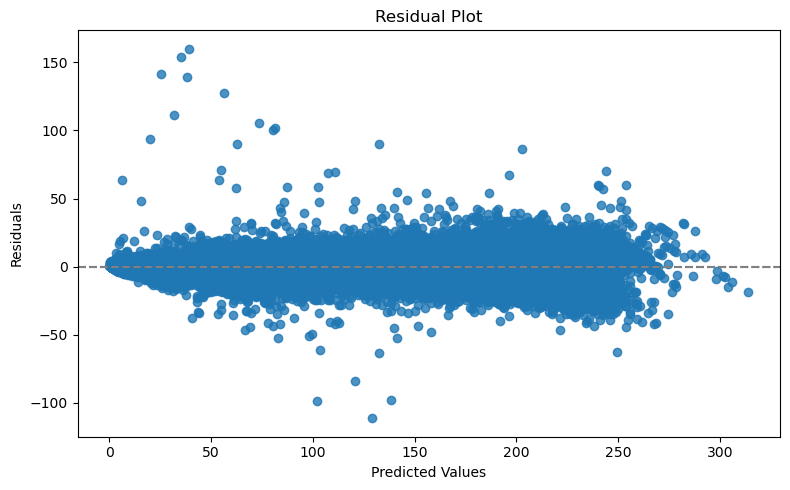

       id    Calories
0  750000   28.202028
1  750001  109.524405
2  750002   89.850288
3  750003  131.117450
4  750004   72.817145

count    250000.000000
mean         88.255048
std          62.101056
min           0.166849
25%          34.156812
50%          76.739814
75%         135.809901
max         304.822757
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.08976 private, 0.08907 public (LinReg_7.csv)

# study.best_trial.params is a dictionary where the keys are features of X and values are True to include and False to ignore
# following line gets the features to include from the optuna study

# feats = [key for key, value in study.best_trial.params.items() if value]

# Best features: ['Sex', 'Weight', 'Duration',
# 'Body_Temp', 'Body_Temp_-_min_sq', 'Age_x_Duration', 
# 'Height_x_Duration', 'Weight_x_Duration', 'Weight_x_Body_Temp', 'Duration_x_Heart_Rate', 'Duration_x_Body_Temp']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X[best_features], drop_first=True), y, test_size=0.2, random_state=724)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 1

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmsle(train_pred, y_train))
print("Test prediction:", rmsle(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=predictions, y=y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

pred = model.predict(pd.get_dummies(test_mod[best_features], drop_first=True))

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = pred
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("LinReg_7.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())